In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
IMGS_PATH = "../Images/3_dias/Mortas/"
# MASKS_PATH = "../Images/3/masks/"
IMGS_CUT_PATH = "../Images/3_dias/Mortas/mortas_cut"
# MASKS_CUT_PATH = "../Images/3/masks_cut/"

def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    plt.figure(figsize=(50, 50))
    plt.imshow(labeled_img)
    plt.show()

def find_extremes(img):
    north = [0, 0]
    south = [0, 0]
    east =[0, 0]
    west = [0, 0]
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y][x] == True:
                if north == [0,0] or west == [0,0]:
                    north = [y,x]
                    west = [y,x]
                if y < north[0]:
                    north = [y,x]
                if x > east[1]:
                    east = [y,x]
                if y > south[0]:
                    south = [y,x]
                if x < west[1]:
                    west = [y,x]
    return north, south, east, west
                    
def draw_box(img, north, south, east, west):
    cv2.line(img, (west[1], south[0]), (east[1], south[0]), (255, 0, 0), 5, 1)
    cv2.line(img, (west[1], north[0]), (east[1], north[0]), (255, 0, 0), 5, 1)
    cv2.line(img, (west[1], south[0]), (west[1], north[0]), (255, 0, 0), 5, 1)
    cv2.line(img, (east[1], north[0]), (east[1], south[0]), (255, 0, 0), 5, 1)
    plt.figure(figsize=(50, 50))
    plt.imshow(img)
    plt.show()

def get_image(img_name):
    image_path = os.path.join(IMGS_PATH, img_name)
    image = cv2.imread(image_path,1)  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image


def get_image_pair(img_name):
    image_path = os.path.join(IMGS_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, img_name)
    image = cv2.imread(image_path,1)  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path,0)
    return image, mask

def pre_process(image):
    kernel = np.ones((5,5),np.uint8)
    
    opening_img = cv2.morphologyEx(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), cv2.MORPH_OPEN, kernel)

    th,thresh_img = cv2.threshold(opening_img, 50, 255, cv2.THRESH_TOZERO)

    num_components, components = cv2.connectedComponents(thresh_img, connectivity=4)
    print("Number of components:", num_components)

    plt.figure(figsize=(50, 50))
    plt.imshow(thresh_img, cmap='gray')
    plt.show()
    
    return num_components, components, thresh_img

def save_image(image_name, image, idx):
    if image is None:
        return
    if image.shape[0] < 40 or image.shape[1] < 40:
        return
    if not os.path.exists(IMGS_CUT_PATH):
        os.makedirs(IMGS_CUT_PATH)
    
    img_path = os.path.join(IMGS_CUT_PATH, image_name.split('.')[0] + "_" + str(idx) + "." + image_name.split('.')[1])
    print(img_path)
    cv2.imwrite(img_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

def save_images(image_name, image, mask, idx):
    if image is None or mask is None:
        return
    if image.shape[0] < 40 or image.shape[1] < 40:
        return
    if not os.path.exists(IMGS_CUT_PATH):
        os.makedirs(IMGS_CUT_PATH)
    if not os.path.exists(MASKS_CUT_PATH):
        os.makedirs(MASKS_CUT_PATH)
    
    img_path = os.path.join(IMGS_CUT_PATH, image_name.split('.')[0] + "_" + str(idx) + "." + image_name.split('.')[1])
    mask_path = os.path.join(MASKS_CUT_PATH, image_name + image_name.split('.')[0] + "_" + str(idx) + "." + image_name.split('.')[1])
    print(img_path, mask_path)
    cv2.imwrite(img_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    cv2.imwrite(mask_path, cv2.cvtColor(mask, cv2.COLOR_RGB2BGR))

def grid_image(image):
    
    # Grid lines at these intervals (in pixels)
    # dx and dy can be different
    dx, dy = 864, 450
    
    if image.shape[0] > image.shape[1]:
        dx, dy = dy, dx

    # Custom (rgb) grid color
    grid_color = [255,255,255]

    # Modify the image to include the grid
    image[:,::dy,:] = grid_color
    image[::dx,:,:] = grid_color
#     plt.figure(figsize=(50, 50))  
#     plt.imshow(image)
#     plt.show()

def cut_images_func(image_names, hasMask = False):
    for image_name in image_names:
        if hasMask is True:
            image, mask = get_image_pair(image_name)
        else:
            image = get_image(image_name)

        print(image.shape)

        num_components, components, processed_image = pre_process(image)   

        for component_idx in range(1, num_components - 1):
            component = components[:,:] == component_idx
            north, south, east, west = find_extremes(component)
            if abs(north[0] - south[0]) < 40 or abs(east[1] - west[1]) < 40:
                print("Corte pequeno demais")
                continue
        #     draw_box(img, north, south, east, west)
            image_cut = image[north[0]:south[0], west[1]:east[1]]
            if hasMask is True:
                mask_cut = mask[north[0]:south[0], west[1]:east[1]]
                save_images(image_name, image_cut, mask_cut, component_idx)
            else:
                save_image(image_name, image_cut, component_idx)
    #         plt.imshow(image_cut)
    #         plt.show()
    #         plt.imshow(mask_cut)
    #         plt.show()

(3456, 4608, 3)
(3456, 4608, 3)
Number of components: 18
Number of components: 31
(3456, 4608, 3)
Number of components: 83


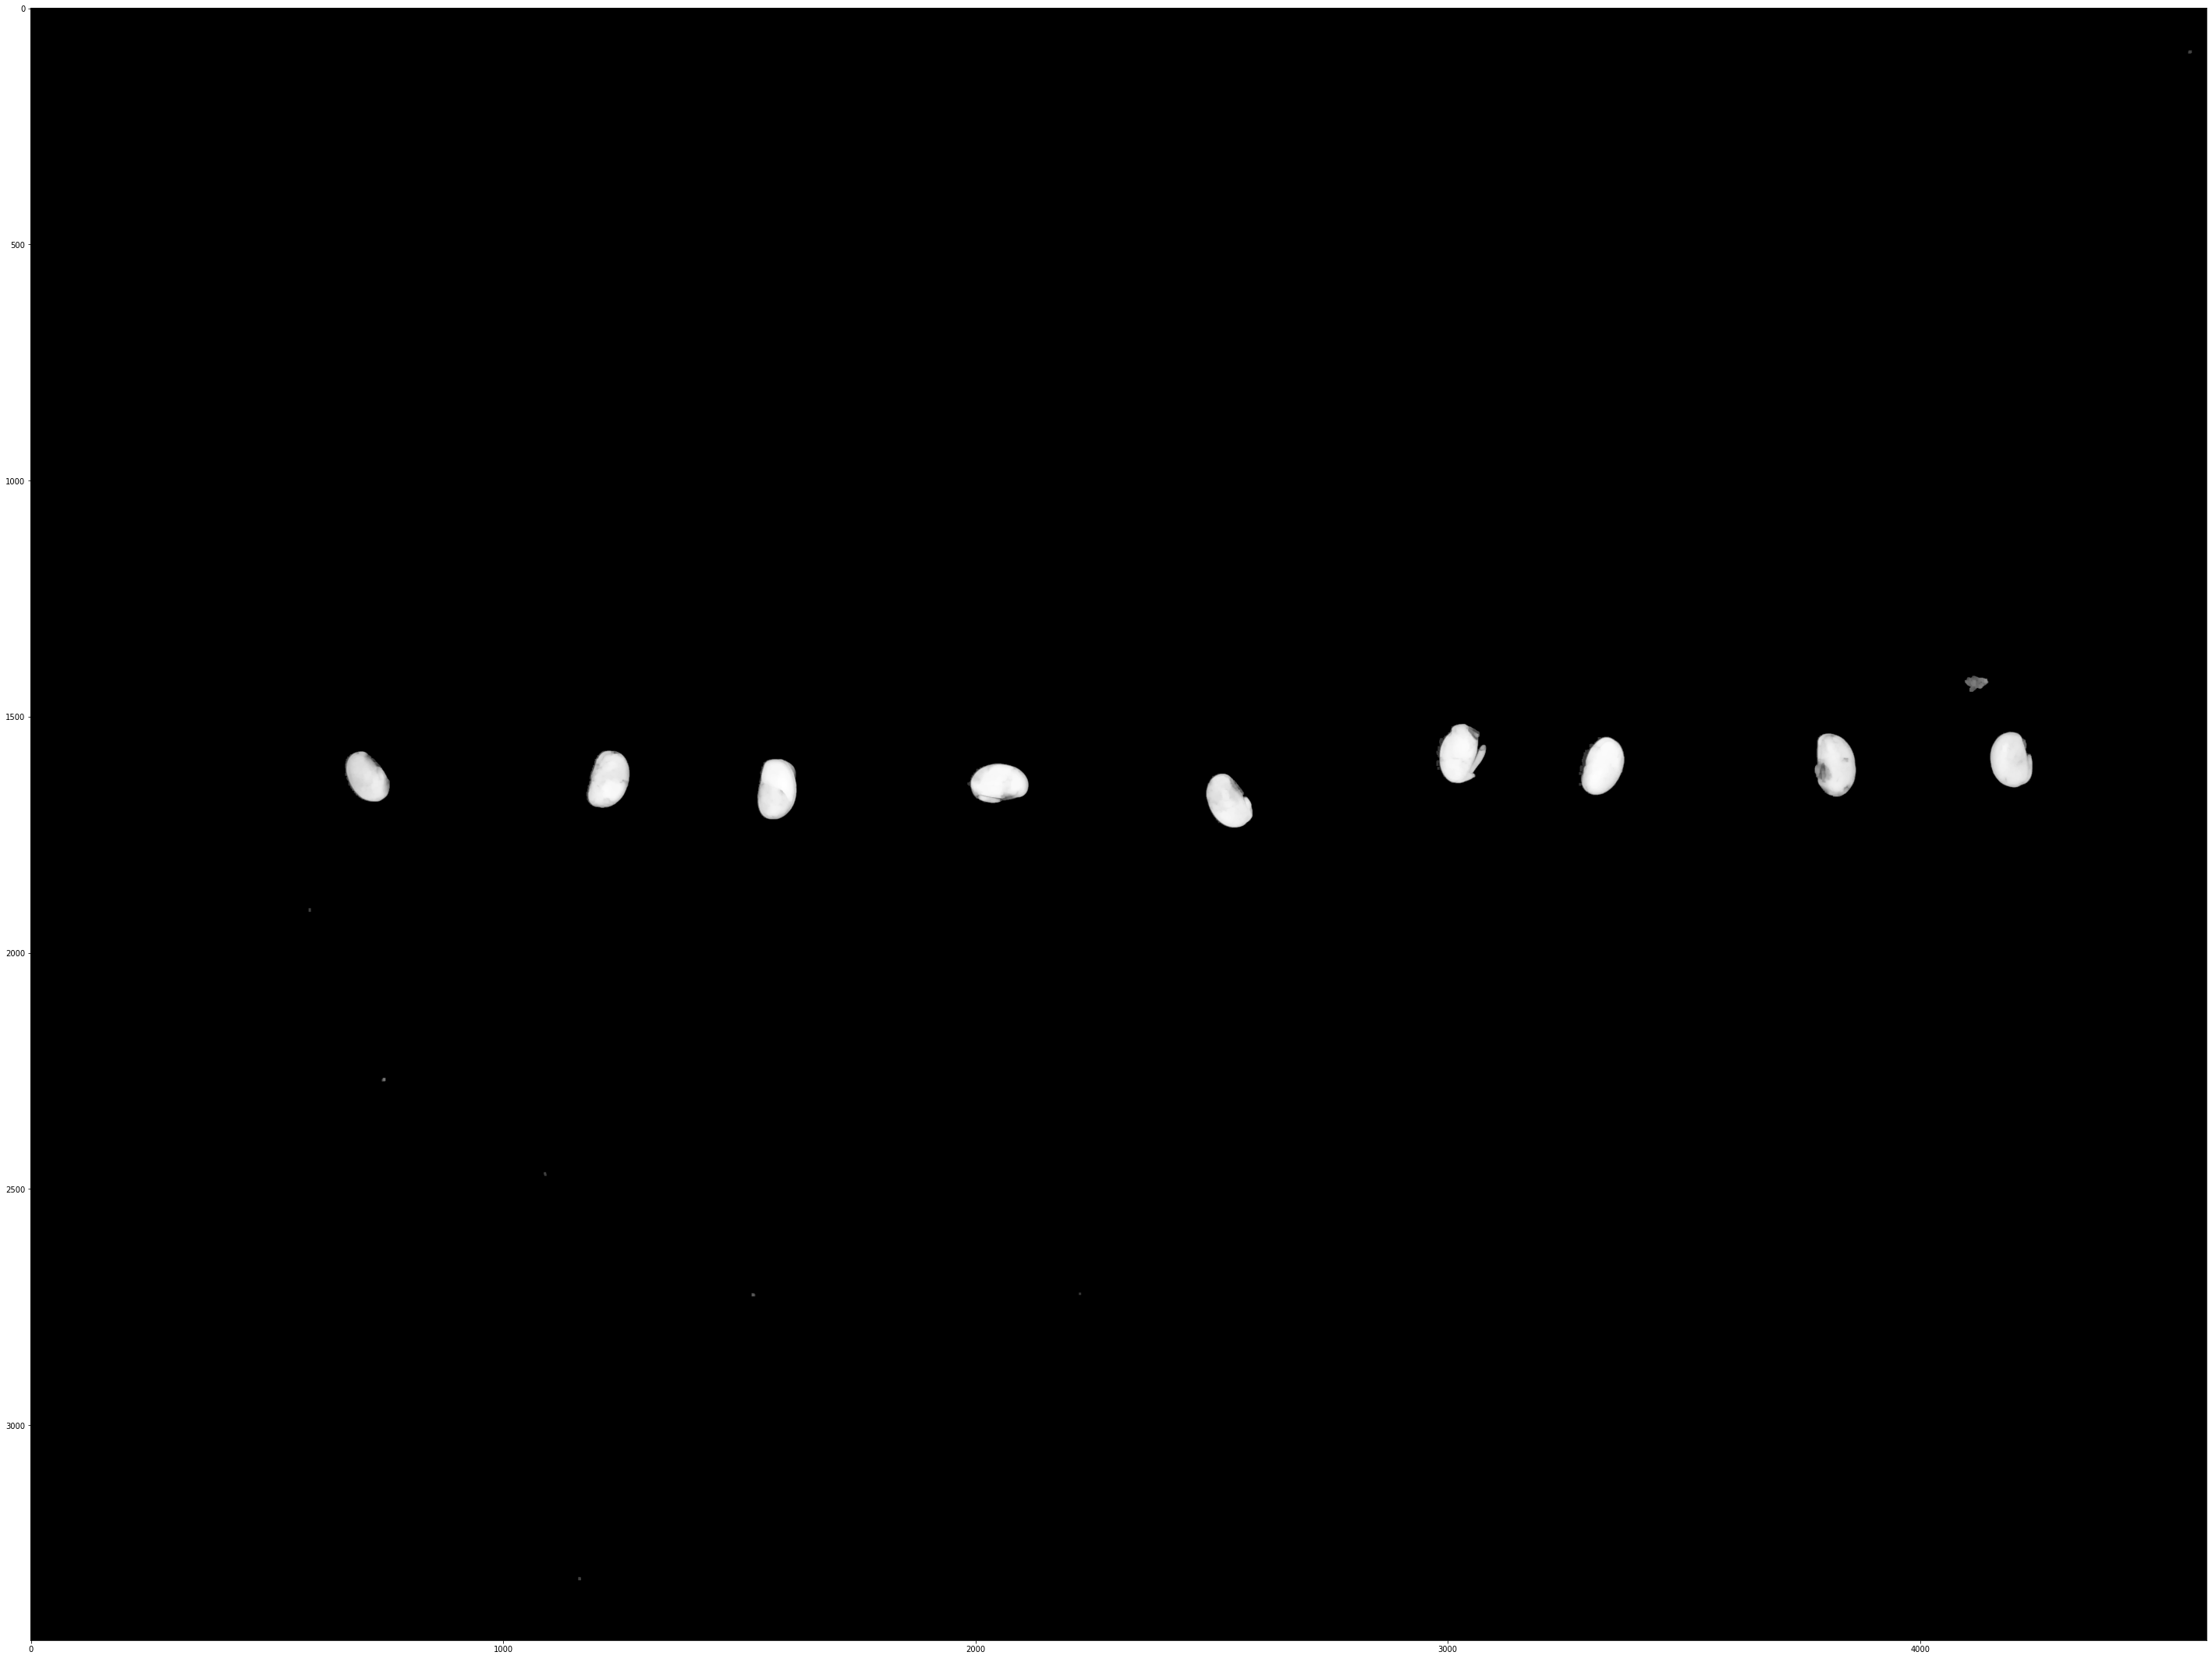

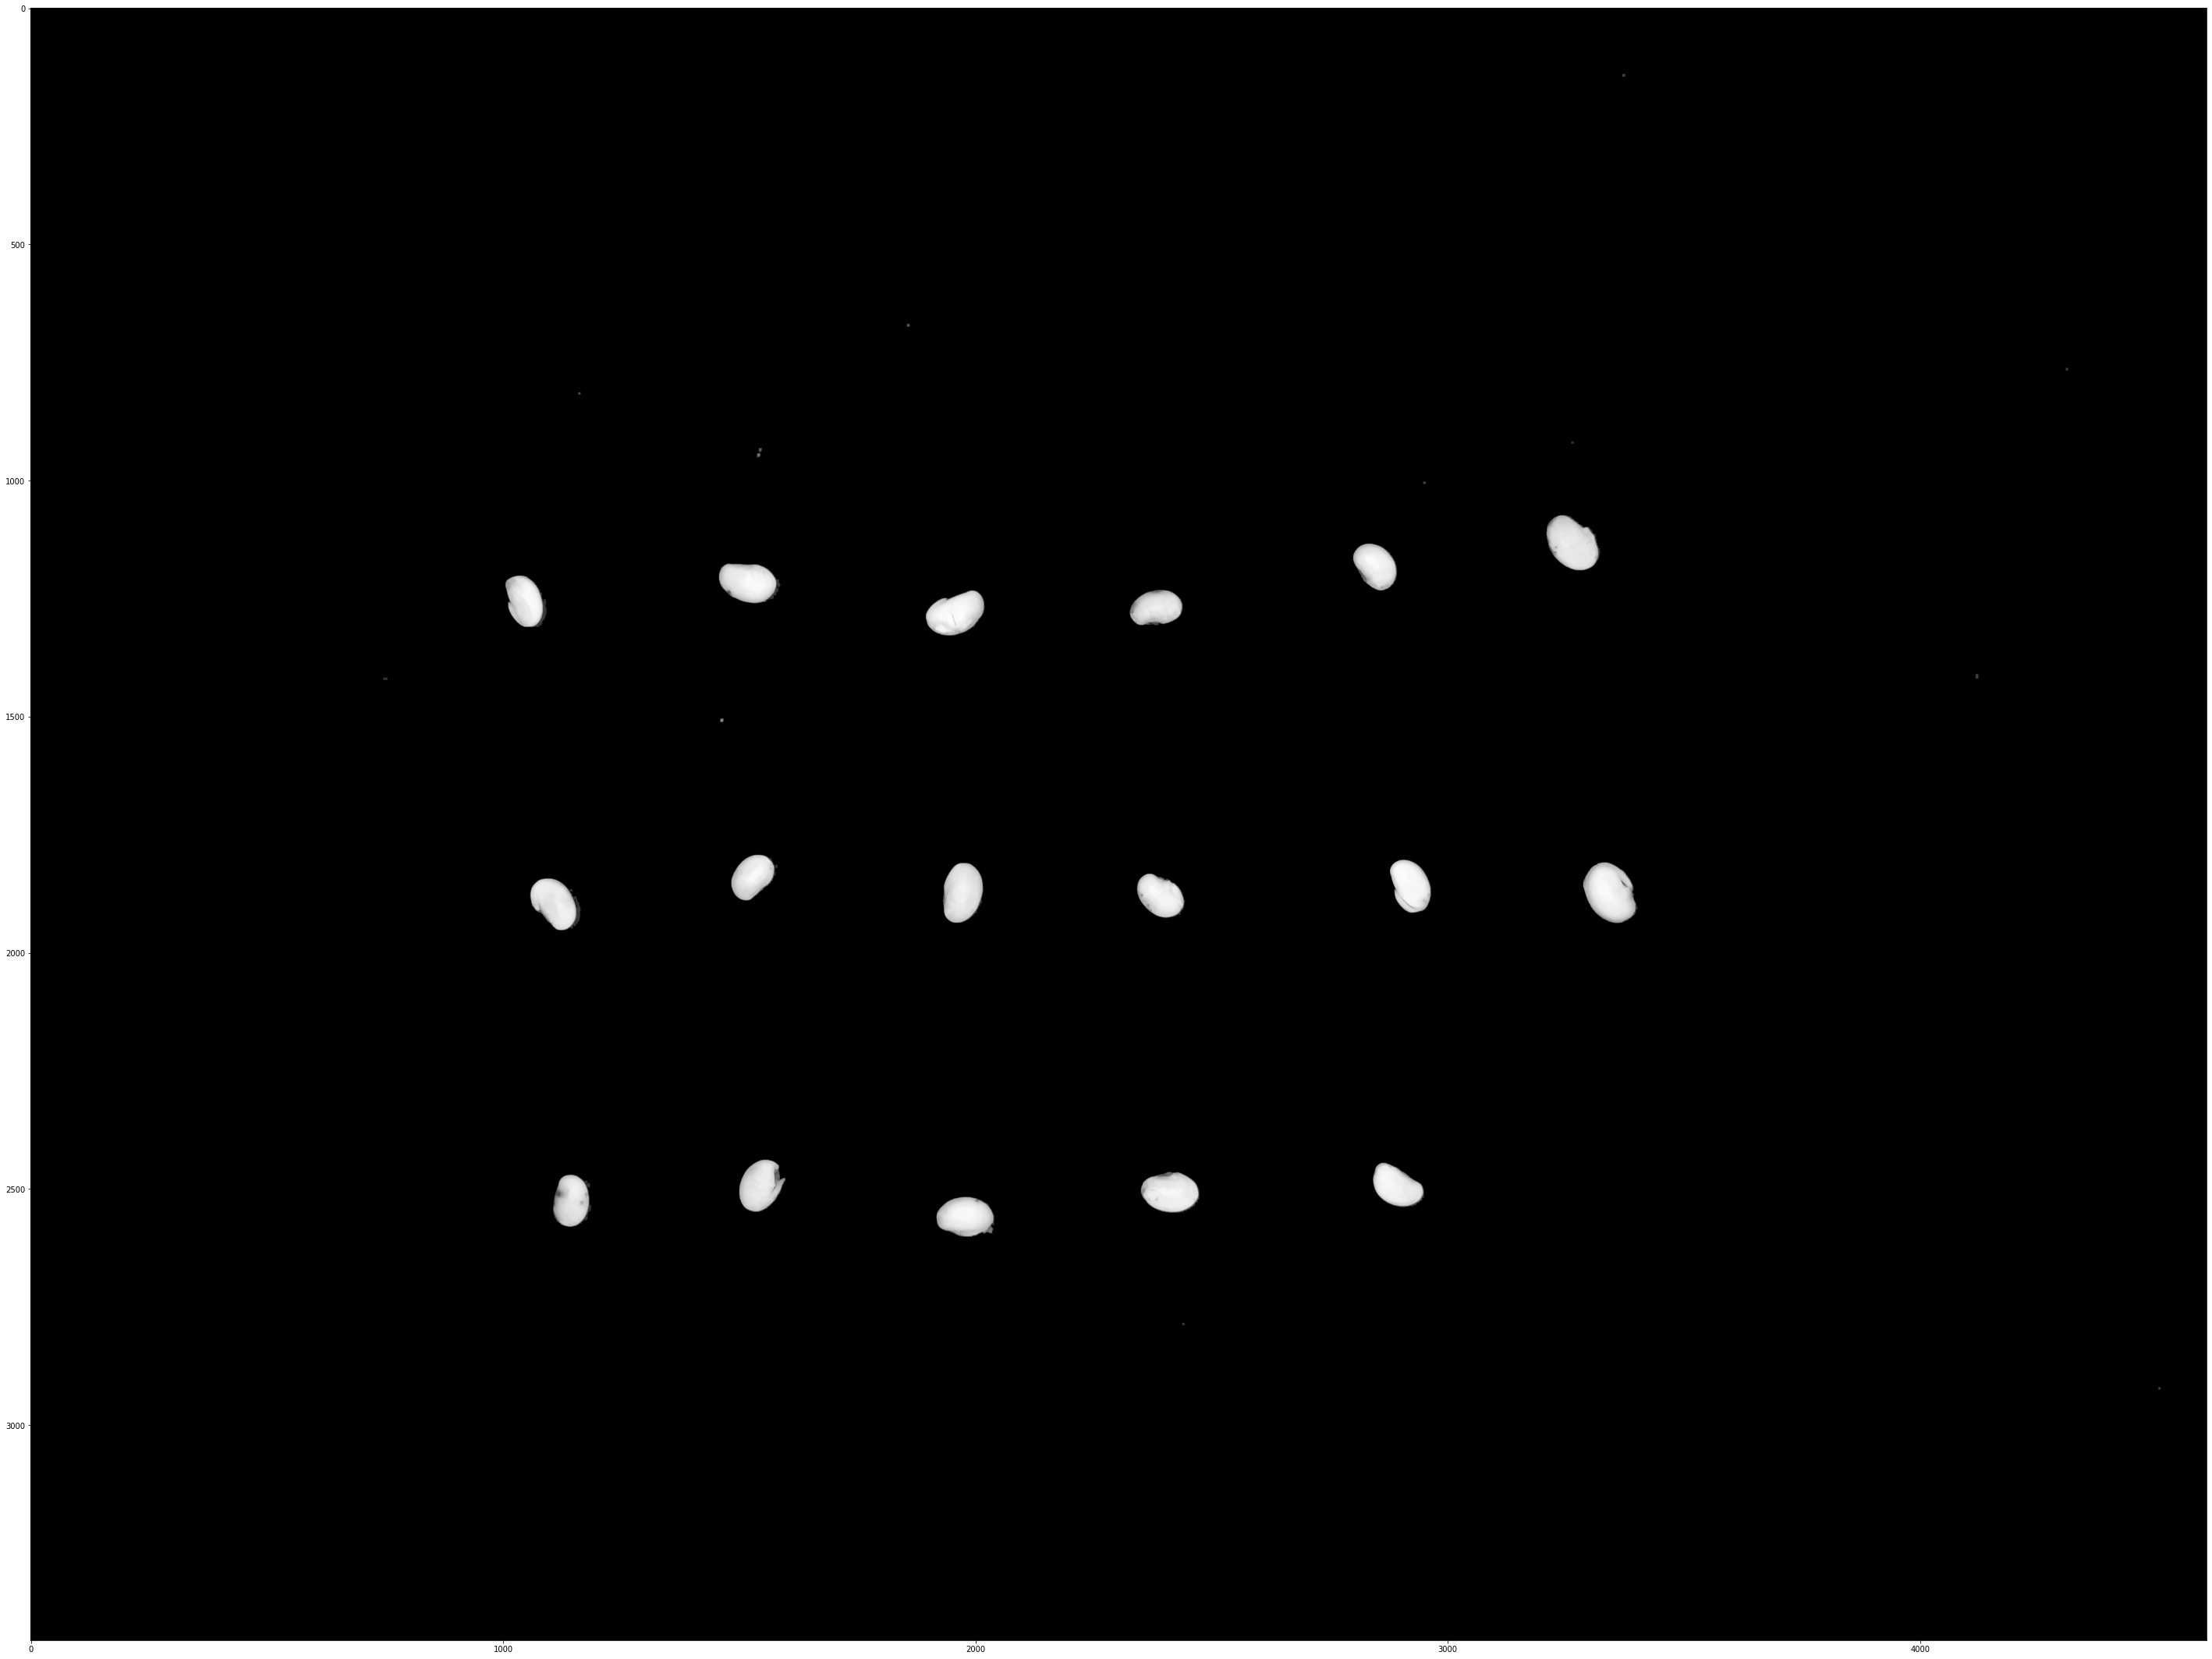

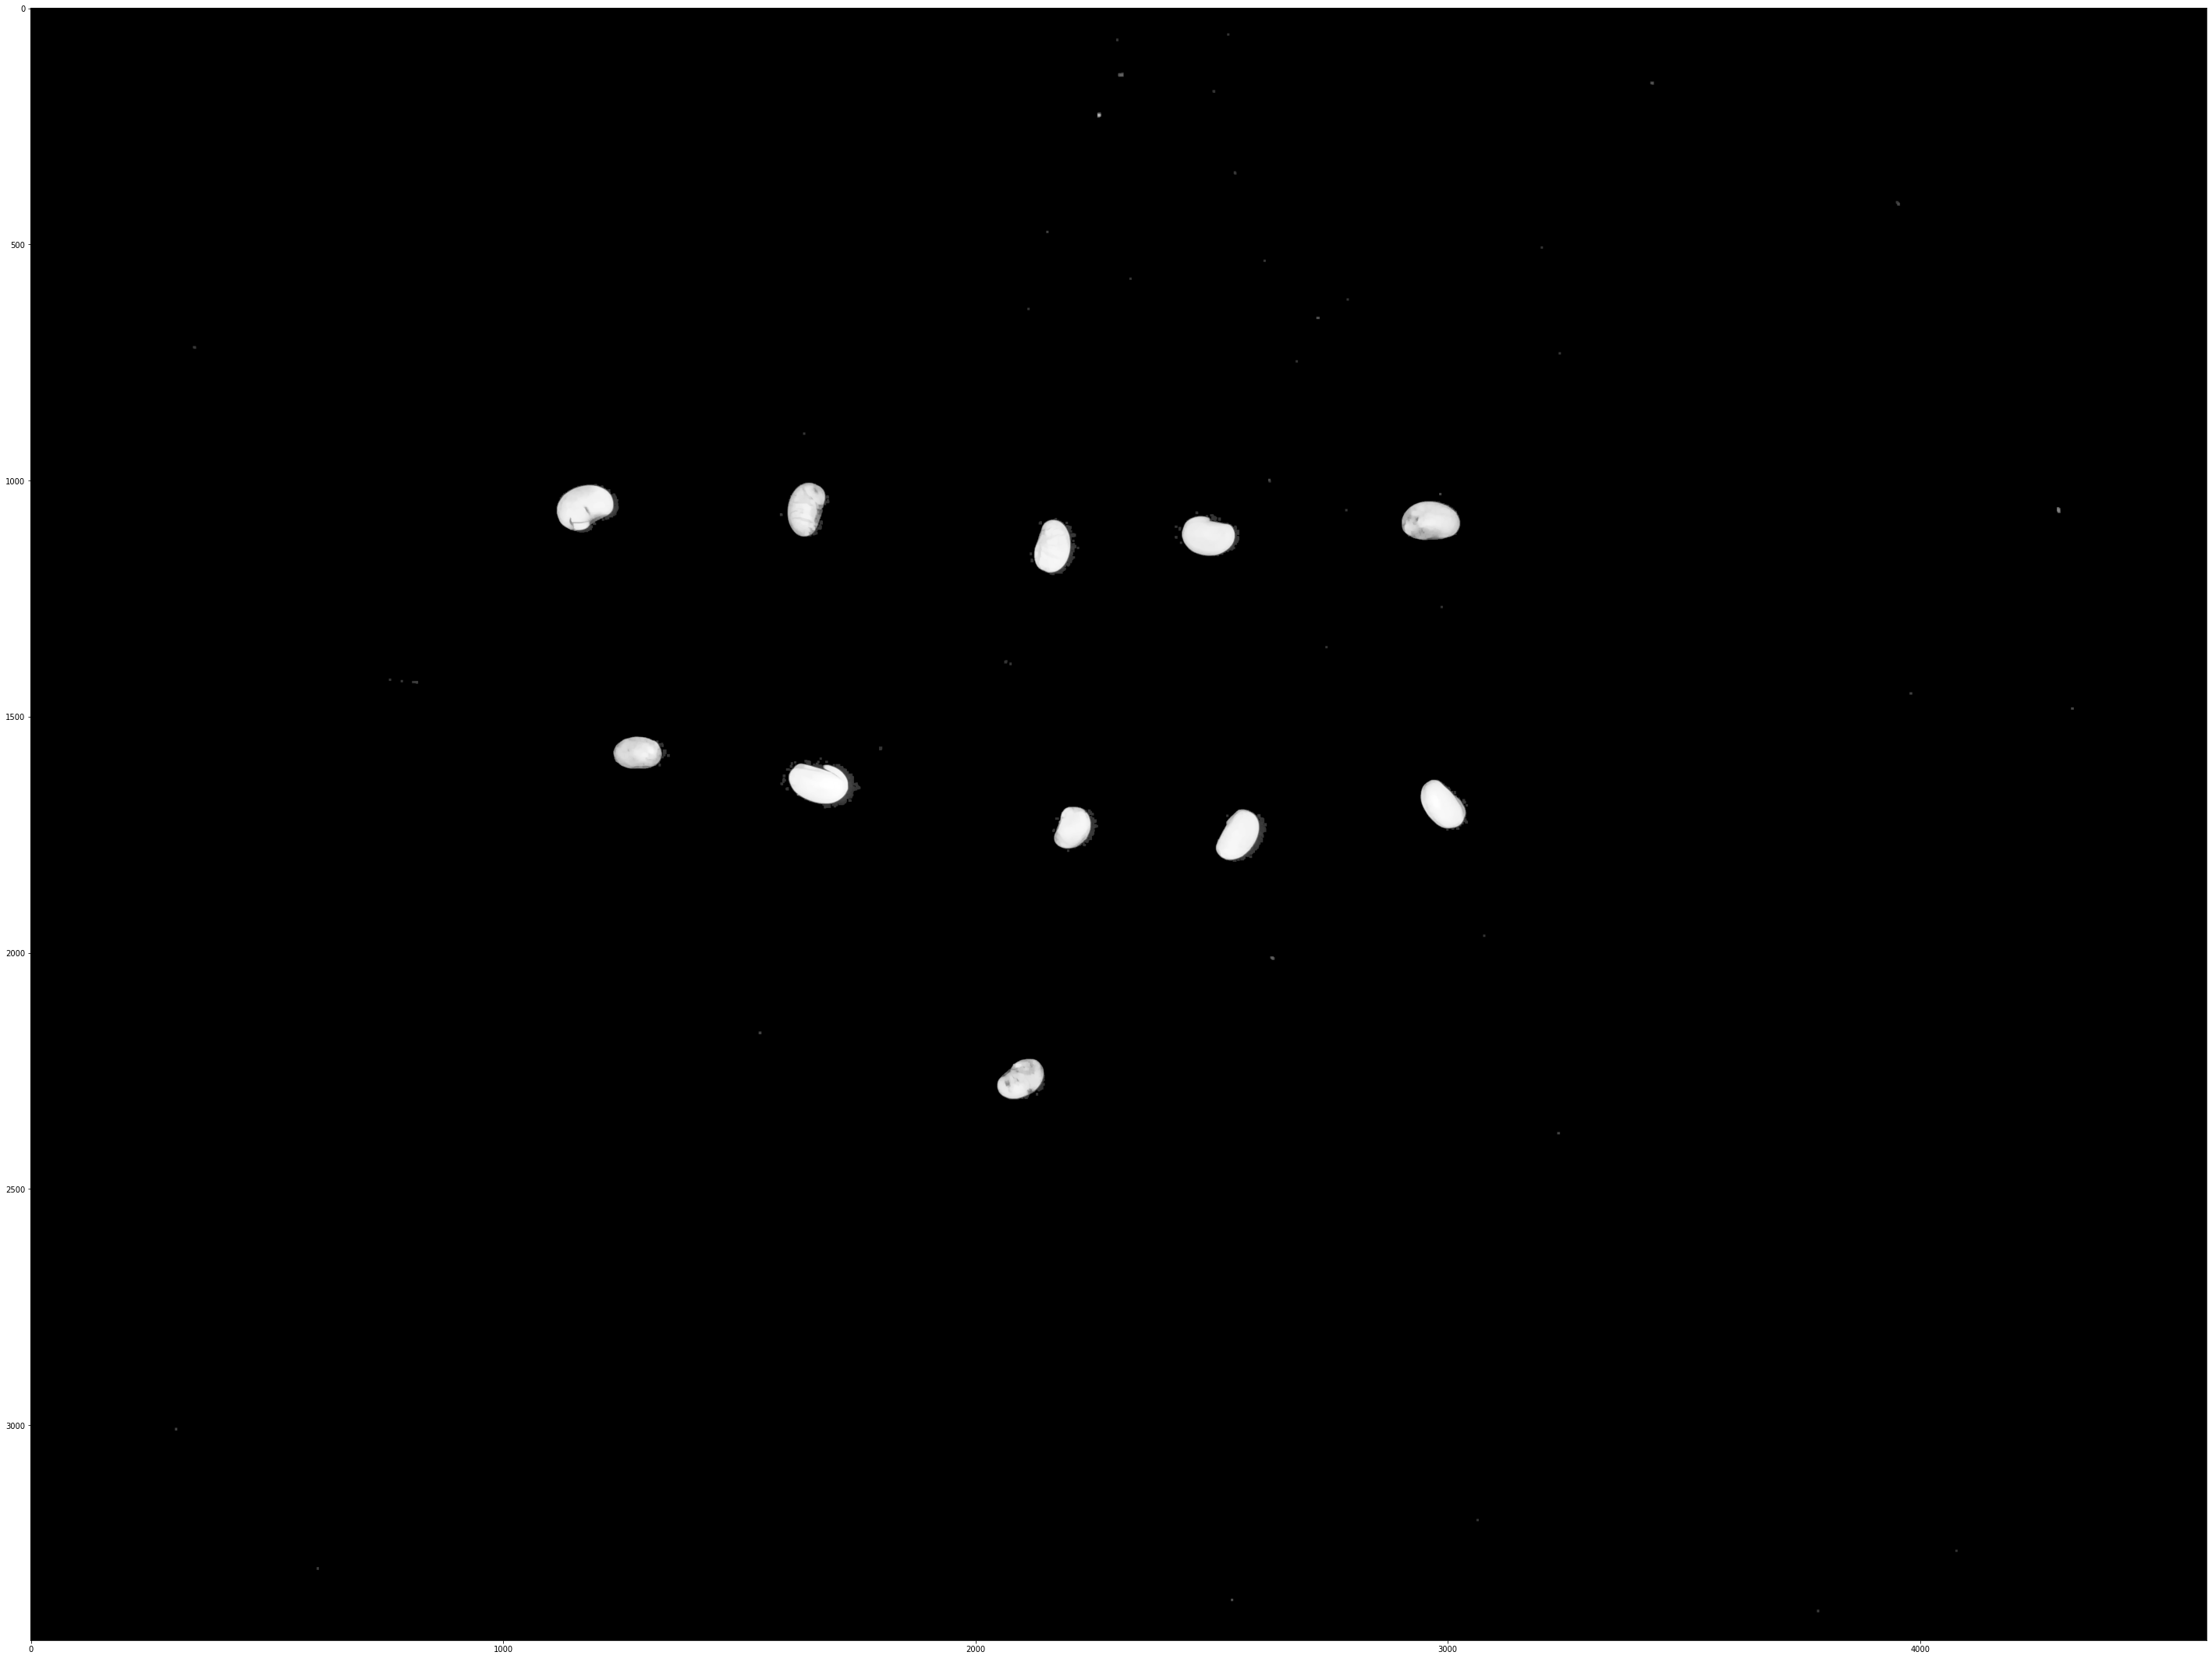

Corte pequeno demais
Corte pequeno demais
Corte pequeno demais
Corte pequeno demais
Corte pequeno demais
Corte pequeno demais
Corte pequeno demais
Corte pequeno demais
../Images/3_dias/Mortas/mortas_cut/IMG_20201009_142240_3.jpg
Corte pequeno demais
Corte pequeno demais
../Images/3_dias/Mortas/mortas_cut/IMG_20201009_142240_4.jpg
Corte pequeno demais
Corte pequeno demais
../Images/3_dias/Mortas/mortas_cut/IMG_20201009_142240_5.jpg
Corte pequeno demais
Corte pequeno demais
../Images/3_dias/Mortas/mortas_cut/IMG_20201009_142240_6.jpg
Corte pequeno demais
Corte pequeno demais
../Images/3_dias/Mortas/mortas_cut/IMG_20201009_142240_7.jpg
Corte pequeno demais
Corte pequeno demais
../Images/3_dias/Mortas/mortas_cut/IMG_20201009_142240_8.jpg
Corte pequeno demais
../Images/3_dias/Mortas/mortas_cut/IMG_20201127_100055_9.jpg
../Images/3_dias/Mortas/mortas_cut/IMG_20201009_142240_9.jpg
Corte pequeno demais
../Images/3_dias/Mortas/mortas_cut/IMG_20201127_100055_10.jpg
../Images/3_dias/Mortas/mortas

Process Process-2:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-176103e88007>", line 143, in cut_images_func
    north, south, east, west = find_extremes(component)
  File "<ipython-input-2-176103e88007>", line 28, in find_extremes
    if img[y][x] == True:
KeyboardInterrupt


In [3]:
image_names = os.listdir(IMGS_PATH)

import multiprocessing 
  
# Yield successive n-sized 
# chunks from l. 
def divide_chunks(l, n): 
      
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

inputs = list(divide_chunks(image_names, 1)) 

processes = list()

for input in inputs:
    x = multiprocessing.Process(target=cut_images_func, args=(input,))
    processes.append(x)
    x.start()    



